# Preserving a spatial quantity of interest (QoI) with safeguards

In this example, we compute the vorticity on a dataset of wind `u`, `v` vectors, which requires taking the derivative along both variables. We compare how three different lossy compressors (ZFP, SZ3, and SPERR) affect the derived vorticity when compressing the `u` and `v` variables (stacked into one variable). Finally, we apply safeguards to guarantee an error bound on the derived vorticity.

Stacking `u` and `v` into one variable that is then compressed is possible because `u` and `v` have very similar data distributions.

This example also showcases how to deal with boundary conditions in spatial data. For instance, the longitude coordinate is periodic and computing a derivative along the longitude needs to handle the periodic coordinates.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5 = ERA5.sel(valid_time="2024-04-02T12:00:00", pressure_level=500)

In [4]:
def compute_vorticity(ERA5: xr.Dataset) -> xr.DataArray:
    earth_radius = 6371000  # [m], globally averaged

    # computing the derivative with a finite difference requires extending the
    #  data domain and tricking xarray for the coordinates
    # e.g. the data needs to be wrapped along the longitude axis,
    #  but the longitude coordinate needs to be extended with odd reflection
    #  ([0, 0.25, ..., 359.75, 360] -> [-0.25, 0, 0.25, ..., 359.75, 360, 360.25])
    #  since xarray cannot handle differentiating along a proper periodic axis
    ERA5_wrapped = (
        ERA5.pad(longitude=1, mode="wrap").pad(
            latitude=1, mode="reflect", reflect_type="even"
        )
    ).assign_coords(
        longitude=ERA5.longitude.pad(longitude=1, mode="reflect", reflect_type="odd"),
        latitude=ERA5.latitude.pad(latitude=1, mode="reflect", reflect_type="odd"),
    )

    # compute the vorticity
    ERA5_dUdTheta = (
        ERA5_wrapped["u"]
        * np.cos(np.deg2rad(ERA5_wrapped["latitude"].astype(ERA5_wrapped["u"].dtype)))
    ).differentiate("latitude")
    ERA5_dVdPhi = ERA5_wrapped["v"].differentiate("longitude")

    ERA5_VOR = (ERA5_dVdPhi - ERA5_dUdTheta) / (
        earth_radius
        * np.cos(np.deg2rad(ERA5_wrapped["latitude"].astype(ERA5_wrapped["u"].dtype)))
    )

    # remove the padding to extract just the valid values
    ERA5_VOR = ERA5_VOR.sel(longitude=slice(0, 359.9), latitude=slice(89.9, -89.9))
    ERA5_VOR.attrs.update(long_name="vorticity", units="s**-1")

    return ERA5_VOR

In [5]:
ERA5_VOR = compute_vorticity(ERA5)

In [6]:
def compute_corrections_percentage(my_ERA5: xr.Dataset, orig_ERA5: xr.Dataset) -> float:
    neq = np.sum(my_ERA5 != orig_ERA5)
    return int(neq.u + neq.v) / int(orig_ERA5.u.size + orig_ERA5.v.size)

In [7]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [8]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [9]:
def plot_vorticity(
    my_ERA5: xr.Dataset,
    cr,
    chart,
    title,
    span,
    vor_eb_abs,
    error=False,
    corr=None,
):
    import copy

    my_ERA5_VOR = compute_vorticity(my_ERA5)

    if error:
        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_VOR - ERA5_VOR).compute()

        err_inf_U = np.amax(np.abs(my_ERA5["u"] - ERA5["u"]))
        err_inf_V = np.amax(np.abs(my_ERA5["v"] - ERA5["v"]))
        err_inf_VOR = np.amax(np.abs(my_ERA5_VOR - ERA5_VOR))
        err_2_VOR = np.sqrt(np.mean(np.square(my_ERA5_VOR - ERA5_VOR)))
        err_v = np.mean(~(np.abs(my_ERA5_VOR - ERA5_VOR) <= vor_eb_abs))

        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        da = my_ERA5_VOR

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )
    style._levels = earthkit.plots.styles.levels.Levels(np.linspace(-span, span, 22))
    style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
    style._colors = "coolwarm" if error else "RdBu"

    extend_left = np.nanmin(da) < -span
    extend_right = np.nanmax(da) > span

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-11)
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        corr = None if corr is None else compute_corrections_percentage(my_ERA5, corr)

        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{u}}}})$={err_inf_U:.02}  "
            + rf"$L_{{{{\infty}}}}(\hat{{{{v}}}})$={err_inf_V:.02}  "
            + rf"$L_{{{{\infty}}}}(\hat{{{{\omega}}}})$={err_inf_VOR:.03}  "
            + rf"$L_{{{{2}}}}(\hat{{{{\omega}}}})$={err_2_VOR:.03}  "
            + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
            + (
                ""
                if corr is None
                else (
                    f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                )
            )
        )
    else:
        chart.title(f"{title}\n")

    if error:
        t = chart.ax.text(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}",
            ha="right",
            va="top",
            transform=chart.ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    counts, bins = np.histogram(da.values.flatten(), range=(-span, span), bins=21)
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    extend_width = (bins[-1] - bins[-2]) / (bins[-1] - bins[0])
    cax = cb.ax.inset_axes(
        [
            0.0 - extend_width * extend_left,
            1.25,
            1.0 + extend_width * (0 + extend_left + extend_right),
            1.0,
        ]
    )
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
    )
    if extend_left:
        cax.bar(
            bins[0] - (bins[1] - bins[0]) / 2,
            height=np.sum(da < -span),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[0])),
        )
    if extend_right:
        cax.bar(
            bins[-1] + (bins[-1] - bins[-2]) / 2,
            height=np.sum(da > span),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[-1])),
        )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(
        -span - (bins[-1] - bins[-2]) * extend_left,
        span + (bins[-1] - bins[-2]) * extend_right,
    )
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

In [10]:
# Since numcodecs-safeguards only supports single-variable safeguarding, we
# stack the u and v variables into a combined variable.
ERA5_UV = np.stack([ERA5["u"].values, ERA5["v"].values], axis=-1)
ERA5.u.dims, ERA5_UV.shape

(('latitude', 'longitude'), (721, 1440, 2))

## Compressing u and v with lossy compressors

We configure each compressor with an absolute error bound of 0.01 m/s over the u-v array, which (mostly) produces errors on the order of $10^{-6}$ on the derived vorticity.

In [11]:
eb_abs = 0.01

In [12]:
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

ERA5_UV_zfp_enc = zfp.encode(ERA5_UV)
ERA5_UV_zfp = zfp.decode(ERA5_UV_zfp_enc)

ERA5_zfp = ERA5.copy(data=dict(u=ERA5_UV_zfp[..., 0], v=ERA5_UV_zfp[..., 1]))
ERA5_zfp_cr = ERA5_UV.nbytes / ERA5_UV_zfp_enc.nbytes

In [13]:
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

ERA5_UV_sz3_enc = sz3.encode(ERA5_UV)
ERA5_UV_sz3 = sz3.decode(ERA5_UV_sz3_enc)

ERA5_sz3 = ERA5.copy(data=dict(u=ERA5_UV_sz3[..., 0], v=ERA5_UV_sz3[..., 1]))
ERA5_sz3_cr = ERA5_UV.nbytes / ERA5_UV_sz3_enc.nbytes

In [14]:
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

ERA5_UV_sperr_enc = sperr.encode(ERA5_UV)
ERA5_UV_sperr = sperr.decode(ERA5_UV_sperr_enc)

ERA5_sperr = ERA5.copy(data=dict(u=ERA5_UV_sperr[..., 0], v=ERA5_UV_sperr[..., 1]))
ERA5_sperr_cr = ERA5_UV.nbytes / ERA5_UV_sperr_enc.nbytes

In [15]:
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

ERA5_UV_zero_enc = zero.encode(ERA5_UV)
ERA5_UV_zero = zero.decode(ERA5_UV_zero_enc)

ERA5_zero = ERA5.copy(data=dict(u=ERA5_UV_zero[..., 0], v=ERA5_UV_zero[..., 1]))

## Compressing u and v using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the pointwise absolute error on the derived vorticity, choosing an error bound of $10^{-8}$ 1/s that is reasonable for the range of the computed baseline vorticity.

The vorticity computation is translated into a quantity of interest over a small local neighbourhood, in which the first-order, second-order-accuracy finite difference is used to approximate the spatial derivatives. For the derivative along the longitude axis, we specify that the coordinates are periodic with a period of 360 degrees to ensure the finite difference on the arbitrary grid is not confused by the coordinate jump at the longitude wrap-around from 0 to 360 degrees.

In [16]:
vor_eb_abs = 1e-8

In [17]:
from numcodecs_safeguards import SafeguardsCodec

ERA5_sg = dict()
ERA5_sg_cr = dict()

for codec in [
    zero,
    zfp,
    sz3,
    sperr,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                V["earth_radius"] = 6371000;  # [m], globally averaged
                
                # extract u and v from the last stacked dimension
                V["u"] = X[I[0], I[1], 0];
                V["v"] = X[I[0], I[1], 1];
                # convert latitude in degrees to radians
                V["latRad"] = c["lat"] * pi / 180;
    
                # approximate the spatial derivatives with finite differences
                V["dUdTheta"] = finite_difference(
                    V["u"] * cos(V["latRad"]),
                    order=1, accuracy=2, type=0, axis=0,
                    grid_centre=c["lat"],
                );
                V["dVdPhi"] = finite_difference(
                    V["v"],
                    order=1, accuracy=2, type=0, axis=1,
                    grid_centre=c["lon"], grid_period=360,
                );
                
                # compute the vorticity
                return (V["dVdPhi"] - V["dUdTheta"]) / (
                    V["earth_radius"] * cos(V["latRad"])
                );
                """,
                type="abs",
                eb=vor_eb_abs,
                neighbourhood=[
                    # latitude
                    dict(axis=0, before=1, after=1, boundary="reflect"),
                    # longitude
                    dict(axis=1, before=1, after=1, boundary="wrap"),
                    # [u, v]
                    dict(axis=-1, before=0, after=1, boundary="valid"),
                ],
            )
        ],
        fixed_constants=dict(
            lat=ERA5.latitude.values.reshape(-1, 1, 1),
            lon=ERA5.longitude.values.reshape(1, -1, 1),
        ),
    )

    ERA5_UV_sg_enc = sg.encode(ERA5_UV)
    ERA5_UV_sg = sg.decode(ERA5_UV_sg_enc)

    ERA5_sg[codec.codec_id] = ERA5.copy(
        data=dict(u=ERA5_UV_sg[..., 0], v=ERA5_UV_sg[..., 1])
    )
    ERA5_sg_cr[codec.codec_id] = ERA5_UV.nbytes / np.asarray(ERA5_UV_sg_enc).nbytes

In [18]:
ERA5_sg_it = dict()
ERA5_sg_it_cr = dict()

for codec in [
    ZeroCodec(),
    zfp,
    sz3,
    sperr,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                V["earth_radius"] = 6371000;  # [m], globally averaged
                
                # extract u and v from the last stacked dimension
                V["u"] = X[I[0], I[1], 0];
                V["v"] = X[I[0], I[1], 1];
                # convert latitude in degrees to radians
                V["latRad"] = c["lat"] * pi / 180;
    
                # approximate the spatial derivatives with finite differences
                V["dUdTheta"] = finite_difference(
                    V["u"] * cos(V["latRad"]),
                    order=1, accuracy=2, type=0, axis=0,
                    grid_centre=c["lat"],
                );
                V["dVdPhi"] = finite_difference(
                    V["v"],
                    order=1, accuracy=2, type=0, axis=1,
                    grid_centre=c["lon"], grid_period=360,
                );
                
                # compute the vorticity
                return (V["dVdPhi"] - V["dUdTheta"]) / (
                    V["earth_radius"] * cos(V["latRad"])
                );
                """,
                type="abs",
                eb=vor_eb_abs,
                neighbourhood=[
                    # latitude
                    dict(axis=0, before=1, after=1, boundary="reflect"),
                    # longitude
                    dict(axis=1, before=1, after=1, boundary="wrap"),
                    # [u, v]
                    dict(axis=-1, before=0, after=1, boundary="valid"),
                ],
            )
        ],
        fixed_constants=dict(
            lat=ERA5.latitude.values.reshape(-1, 1, 1),
            lon=ERA5.longitude.values.reshape(1, -1, 1),
        ),
        # use iteration to refine the corrections
        compute=dict(_unstable_iterative=True),
    )

    ERA5_UV_sg_it_enc = sg.encode(ERA5_UV)
    ERA5_UV_sg_it = sg.decode(ERA5_UV_sg_it_enc)

    ERA5_sg_it[codec.codec_id] = ERA5.copy(
        data=dict(u=ERA5_UV_sg_it[..., 0], v=ERA5_UV_sg_it[..., 1])
    )
    ERA5_sg_it_cr[codec.codec_id] = (
        ERA5_UV.nbytes / np.asarray(ERA5_UV_sg_it_enc).nbytes
    )

## Visual comparison of the error distributions for the derived vorticity

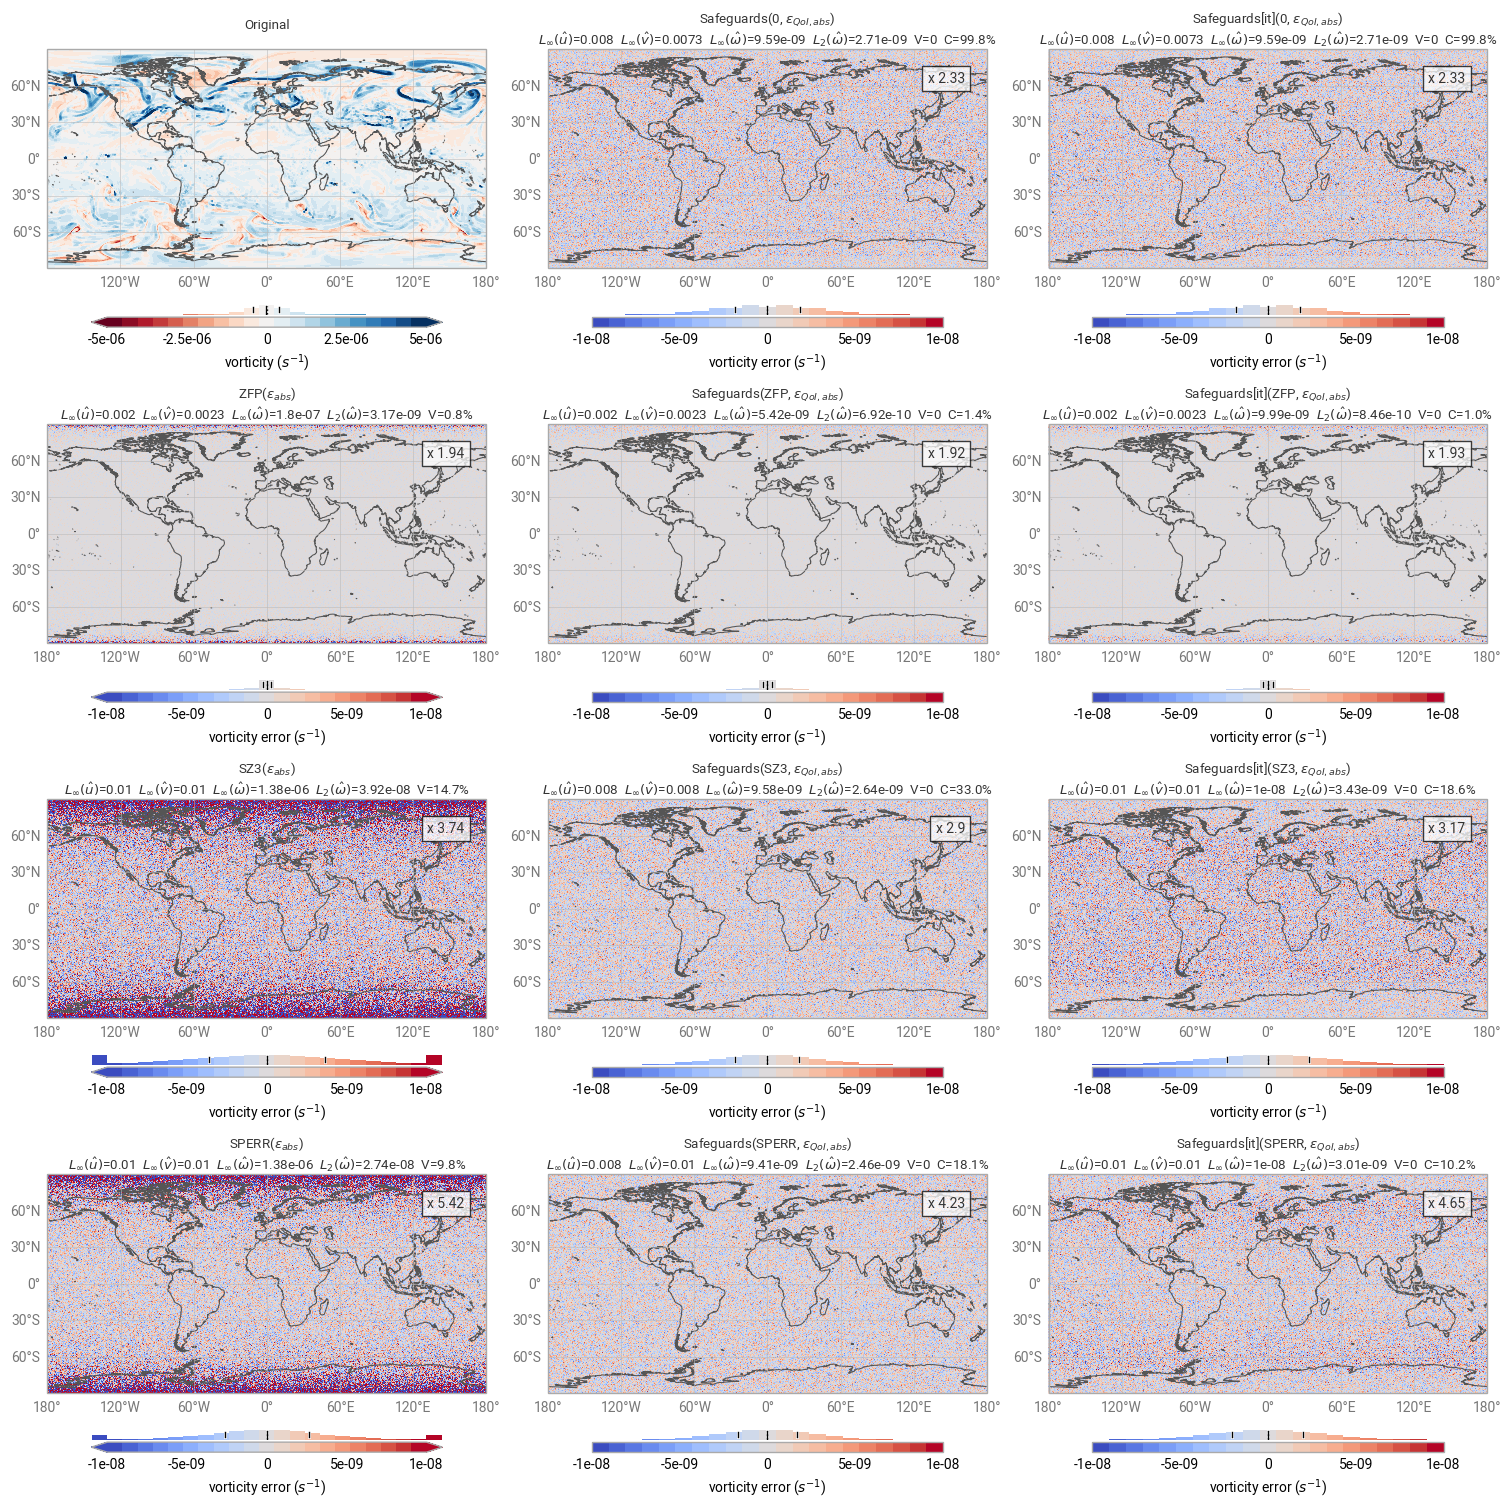

In [19]:
fig = earthkit.plots.Figure(
    size=(15, 15),
    rows=4,
    columns=3,
)

plot_vorticity(
    ERA5, 1.0, fig.add_map(0, 0), "Original", span=5e-6, vor_eb_abs=vor_eb_abs
)
plot_vorticity(
    ERA5_zfp,
    ERA5_zfp_cr,
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
)
plot_vorticity(
    ERA5_sz3,
    ERA5_sz3_cr,
    fig.add_map(2, 0),
    r"SZ3($\epsilon_{{abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
)
plot_vorticity(
    ERA5_sperr,
    ERA5_sperr_cr,
    fig.add_map(3, 0),
    r"SPERR($\epsilon_{{abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
)

plot_vorticity(
    ERA5_sg["zero"],
    ERA5_sg_cr["zero"],
    fig.add_map(0, 1),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_zero,
)
plot_vorticity(
    ERA5_sg["zfp.rs"],
    ERA5_sg_cr["zfp.rs"],
    fig.add_map(1, 1),
    r"Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_zfp,
)
plot_vorticity(
    ERA5_sg["sz3.rs"],
    ERA5_sg_cr["sz3.rs"],
    fig.add_map(2, 1),
    r"Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_sz3,
)
plot_vorticity(
    ERA5_sg["sperr.rs"],
    ERA5_sg_cr["sperr.rs"],
    fig.add_map(3, 1),
    r"Safeguards(SPERR, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_sperr,
)

plot_vorticity(
    ERA5_sg_it["zero"],
    ERA5_sg_it_cr["zero"],
    fig.add_map(0, 2),
    r"Safeguards[it](0, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_zero,
)
plot_vorticity(
    ERA5_sg_it["zfp.rs"],
    ERA5_sg_it_cr["zfp.rs"],
    fig.add_map(1, 2),
    r"Safeguards[it](ZFP, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_zfp,
)
plot_vorticity(
    ERA5_sg_it["sz3.rs"],
    ERA5_sg_it_cr["sz3.rs"],
    fig.add_map(2, 2),
    r"Safeguards[it](SZ3, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_sz3,
)
plot_vorticity(
    ERA5_sg_it["sperr.rs"],
    ERA5_sg_it_cr["sperr.rs"],
    fig.add_map(3, 2),
    r"Safeguards[it](SPERR, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_sperr,
)

fig.save("vorticity.pdf")